In [73]:
%reset -f

In [1]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [2]:
base_path = os.path.join(os.getcwd(), "CBI Analysis")

# Import df_all and raw data for IAS & PCS
df_all = pd.read_excel(os.path.join(base_path, "df_all.xlsx"))
df_IAS_raw = pd.read_excel(os.path.join(base_path, "2022_2025_Faculty Load Analysis w. Class # - CLEANED.xlsx"))
df_PCS_raw = pd.read_excel(os.path.join(base_path, "Course List w. Pre-Reqs.xlsx"))

Import the Semester Sort Function

In [3]:
# Strategy: label Fall/Spring starting with the same year, to count them as the same academic year
# e.g. Fall 2021 & Spring 2022 will turn into 2021.0 and 2021.5, to group as the 2021 academic year

def semester_order_func(sem):
    season, year = sem.split()
    year = int(year)
    if season == "Fall":
        return year + 0.0           # Fall 2021 turns into 2021.0; Fall 2021 into 2022.0; etc
    elif season == "Spring":
        return (year - 1) + 0.5     # Spring 2022 - 1 + 0.5 = 2021.5 so that it'll follow Fall 2021.0

<h1> Course Bottleneck Index (CBI) KDD </h1>

<h3> Begin with Defining Terms: DR, OFS, IAS, PCS </h3>

<h2> Demand Ratio (DR)</h2>
DR = enrollment / capacity

Data Cleanse for DR, group Co-Convened Courses

In [4]:
df_DR_all = df_all.copy()

# Co-Convened? no: df_n_coconvened, yes: df_y_coconvened
df_n_coconvened = df_DR_all[df_DR_all["Combined Section"] == "-"] # Whether or not value = "-"
df_y_coconvened = df_DR_all[df_DR_all["Combined Section"] != "-"]

# Co-Convened Yes Modifications -->
# Feed to Aggregate Dictionary: 1) grouping columns; 2) sum columns; 3) all remaining columns, keep "first" value
cc_group_cols = ["Term", "Combined Section"]           # same "term" & "combined section" -> yes co-convened
cc_sum_cols = ["Total Enroll", "Enrollment Capacity"]  # sum Enroll & Capacity if co-convened
cc_first_cols = [col for col in df_y_coconvened.columns if col not in cc_group_cols + cc_sum_cols] # all other cols, keep first value

# Build the aggregate dictionary for Co-Convened Yes
cc_agg_dict = {col: "sum" for col in cc_sum_cols}
cc_agg_dict.update({col: "first" for col in cc_first_cols})

# Co-Convened Yes: Group and aggregate
df_y_coconvened = df_y_coconvened.groupby(cc_group_cols, as_index=False).agg(cc_agg_dict)

# Concatenate the y/n Co-Convened DFs together
df_DR_all = pd.concat([df_n_coconvened, df_y_coconvened], ignore_index=True)

print("df_DR_all had",df_all.shape[0], "rows before consolidating the co-convened classes")
print("\ndf_DR_all has",df_DR_all.shape[0], "rows after consolidating the co-convened classes")

df_DR_all had 1559 rows before consolidating the co-convened classes

df_DR_all has 1047 rows after consolidating the co-convened classes


DR for every class

In [5]:
#DR for Every Individual Class
df_DR_all["DR"] = (df_DR_all["Total Enroll"] / df_DR_all["Enrollment Capacity"]).round(2)

Explore missing values for DR

In [6]:
df_DR_missing = df_DR_all[df_DR_all["DR"].isna()]
# All of them are classes with no enrollments & no capacity

# Fill missing values with 0s (discussed with mentor, these were cancelled classes)
df_DR_all["DR"] = df_DR_all["DR"].fillna(0)

# Drop the 2 (discussion) classes that had Enrollments but didn't have Enrollment Capacity (DR = "inf")
# Statistic Foundations Info Age & Dealing with Data
df_DR_all = df_DR_all[df_DR_all["DR"].astype(str) != "inf"]

Finalize data cleansing for df_DR_all

DR: Total by Course

In [7]:
df_avg_DR = (df_DR_all.groupby("Course Description", as_index=False)["DR"].mean()).round(2)
print("Average DR by Course:")
print(df_avg_DR)

Average DR by Course:
               Course Description    DR
0       Advanced Game Development  0.27
1             Advanced Web Design  0.33
2            Algorithms for Games  0.68
3   Applied Cyberinfrastruct Conc  0.14
4      Applied Data Visualization  0.68
..                            ...   ...
76          Theories of New Media  0.47
77       User Interf+Website Dsgn  0.06
78                Virtual Reality  0.38
79        Visual Content Creation  0.52
80              eSport Industries  0.70

[81 rows x 2 columns]


DR Total - Summary Stats

In [8]:
# Overall stats
dr_mean = round(df_avg_DR["DR"].mean(), 2)
dr_median = round(df_avg_DR["DR"].median(), 2)
dr_std = round(df_avg_DR["DR"].std(), 2)

print("DR Summary Statistics (Overall):")
print(f"Mean DR: {dr_mean}")
print(f"Median DR: {dr_median}")
print(f"Standard Deviation: {dr_std}")


# DR min/max and course name
dr_min = round(df_avg_DR["DR"].min(), 2)
dr_max = round(df_avg_DR["DR"].max(), 2)
course_min = df_avg_DR.loc[df_avg_DR["DR"] == dr_min, "Course Description"].tolist() #Course name(s) as list
course_max = df_avg_DR.loc[df_avg_DR["DR"] == dr_max, "Course Description"].tolist()

print(f"Min DR: {dr_min} — Courses: {course_min}")
print(f"Max DR: {dr_max} — Courses: {course_max}")

# Top 10 highest and lowest DR courses
top_dr = df_avg_DR.nlargest(10, "DR")
bottom_dr = df_avg_DR.nsmallest(10, "DR")

print("\n10 Highest DR Courses:")
print(top_dr)
print("\n10 Lowest DR Courses:")
print(bottom_dr)


DR Summary Statistics (Overall):
Mean DR: 0.44
Median DR: 0.52
Standard Deviation: 0.24
Min DR: 0.0 — Courses: ['Natural Language Processing', 'Simulation and Problem Solving', 'Special Topics in LIS']
Max DR: 0.91 — Courses: ['Digital Crime & Social Media']

10 Highest DR Courses:
                Course Description    DR
22    Digital Crime & Social Media  0.91
42             Installation Design  0.87
12          Computing and the Arts  0.85
11  Computational Thinking & Doing  0.84
31       Ethics in a Digital World  0.75
69      Social Media and Ourselves  0.75
52  Intro: Human Computer Interact  0.73
53     Introduction to Game Design  0.73
80               eSport Industries  0.70
37     Great Ideas of the Info Age  0.69

10 Lowest DR Courses:
                Course Description    DR
57     Natural Language Processing  0.00
67  Simulation and Problem Solving  0.00
72           Special Topics in LIS  0.00
10    Computational Social Science  0.01
14                     Data Ethics  0.

DR: By Term & Course

In [9]:
df_term_avg_DR = (df_DR_all.groupby(["Term", "Course Description"], as_index=False)["DR"].mean()).round(2)

# Sort by Term
df_term_avg_DR = df_term_avg_DR.set_index(["Term", "Course Description"])
df_term_avg_DR = df_term_avg_DR.loc[sorted(df_term_avg_DR.index, key=lambda x: semester_order_func(x[0]))]
df_term_avg_DR = df_term_avg_DR.reset_index()

print("Average DR by Course & Term:")
print(df_term_avg_DR)

Average DR by Course & Term:
            Term             Course Description    DR
0      Fall 2021            Advanced Web Design  0.26
1      Fall 2021           Algorithms for Games  0.52
2      Fall 2021  Applied Cyberinfrastruct Conc  0.22
3      Fall 2021     Applied Data Visualization  0.72
4      Fall 2021  Bayesian Modeling & Inference  0.09
..           ...                            ...   ...
475  Spring 2025         The Past and New Media  0.34
476  Spring 2025          Theories of New Media  0.32
477  Spring 2025                Virtual Reality  0.46
478  Spring 2025        Visual Content Creation  0.52
479  Spring 2025              eSport Industries  0.50

[480 rows x 3 columns]


DR by Term - Summary Stats

In [10]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom 5 courses
for df_semester, group in df_term_avg_DR.groupby("Term"):
    # Summary stats (mean, median, std)
    dr_mean = round(group["DR"].mean(), 2)
    dr_median = round(group["DR"].median(), 2)
    dr_std = round(group["DR"].std(), 2)
    print(f"\n🗓 DR Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean DR: {dr_mean}")
    print(f"Median DR: {dr_median}")
    print(f"Standard Deviation: {dr_std}")

    # Min/Max and course name(s)
    dr_min = round(group["DR"].min(), 2)
    dr_max = round(group["DR"].max(), 2)
    course_min = group.loc[group["DR"] == dr_min, "Course Description"].tolist()
    course_max = group.loc[group["DR"] == dr_max, "Course Description"].tolist()
    print(f"Min DR: {dr_min} on Courses: {course_min}")
    print(f"Max DR: {dr_max} on Courses: {course_max}")

    #Top/Bottom 5
    top_5 = group.nlargest(5, "DR")[["Course Description", "DR"]]
    bottom_5 = group.nsmallest(5, "DR")[["Course Description", "DR"]]
    print(f"\n{df_semester}: 5 Highest DR Courses:")
    print(top_5.to_string(index=False))
    print(f"\n {df_semester}: 5 Lowest DR Courses:")
    print(bottom_5.to_string(index=False))



🗓 DR Summary for Fall 2021
Mean DR: 0.55
Median DR: 0.6
Standard Deviation: 0.29
Min DR: 0.0 on Courses: ['Simulation and Problem Solving', 'Virtual Reality']
Max DR: 1.02 on Courses: ['eSport Industries']

Fall 2021: 5 Highest DR Courses:
          Course Description   DR
           eSport Industries 1.02
 Great Ideas of the Info Age 1.01
Digital Crime & Social Media 0.96
  Social Media and Ourselves 0.96
    Intro to Creative Coding 0.95

 Fall 2021: 5 Lowest DR Courses:
            Course Description   DR
Simulation and Problem Solving 0.00
               Virtual Reality 0.00
 Ethical Issues in Information 0.03
 Bayesian Modeling & Inference 0.09
      User Interf+Website Dsgn 0.09

🗓 DR Summary for Fall 2022
Mean DR: 0.57
Median DR: 0.63
Standard Deviation: 0.28
Min DR: 0.0 on Courses: ['Virtual Reality']
Max DR: 0.98 on Courses: ['Diversity and Bias in Games', 'eSport Industries']

Fall 2022: 5 Highest DR Courses:
          Course Description   DR
 Diversity and Bias in Games 0.9


Spring 2023: 5 Highest DR Courses:
           Course Description   DR
    Ethics in a Digital World 1.01
 Collaborating: Online Commun 0.98
       Computing and the Arts 0.96
Hacking & Open Source Culture 0.96
  Introduction to Game Design 0.94

 Spring 2023: 5 Lowest DR Courses:
            Course Description  DR
          Business Information 0.0
 Ethical Issues in Information 0.0
Intellectual Property/Copyrigh 0.0
   Natural Language Processing 0.0
            Princ Data Science 0.0

🗓 DR Summary for Spring 2024
Mean DR: 0.45
Median DR: 0.46
Standard Deviation: 0.26
Min DR: 0.0 on Courses: ['Computational Social Science', 'Info Trust and Manipulation', 'Princ Data Science', 'Special Topics in LIS']
Max DR: 0.98 on Courses: ['Digital Commerce']

Spring 2024: 5 Highest DR Courses:
            Course Description   DR
              Digital Commerce 0.98
    Applied Data Visualization 0.97
  Intro Web Design-Development 0.96
Computational Thinking & Doing 0.93
        Computing and the 

<h2>Offering Frequency Score (OFS)</h2>
Captures how often a course if offered: 1: every semester, 2: once a year, 3: less than once a year

Total Courses by "Course Description"

In [11]:
# Total Courses by "Course Description"
course_totals = df_all.groupby("Course Description").size().sort_values(ascending=False)
print("Total Classes by Course Description:")
print(course_totals)

Total Classes by Course Description:
Course Description
Statistic Foundations Info Age    77
Digital Storytelling & Culture    74
Computational Thinking & Doing    72
Social Media and Ourselves        50
Dealing with Data                 49
                                  ..
Foundation of Info & Inference     2
Game AI                            2
Designing an Installation          2
Natural Language Processing        1
Visual Content Creation            1
Length: 81, dtype: int64


Total Courses by Term

In [12]:
course_total_by_semester = df_all.groupby(["Course Description", "Term"]).size().unstack(fill_value=0)
course_total_by_semester = course_total_by_semester[sorted(course_total_by_semester.columns, key=semester_order_func)]
course_total_by_semester = course_total_by_semester.reset_index()   #Include Course Description as a column, was being dropped

print("Total Classes by Semester:")
print(course_total_by_semester)

Total Classes by Semester:
Term             Course Description  Fall 2021  Spring 2022  Fall 2022  \
0         Advanced Game Development          0            1          1   
1               Advanced Web Design          2            2          0   
2              Algorithms for Games          1            1          1   
3     Applied Cyberinfrastruct Conc          6            0          0   
4        Applied Data Visualization          2            2          2   
..                              ...        ...          ...        ...   
76            Theories of New Media          8            6          4   
77         User Interf+Website Dsgn          2            2          0   
78                  Virtual Reality          1            1          1   
79          Visual Content Creation          0            0          0   
80                eSport Industries          2            4          2   

Term  Spring 2023  Fall 2023  Spring 2024  Fall 2024  Spring 2025  
0               

Function: Get OFS Score (get_OFS)

1: Every Semester. 2: Once a year. 3: Less than once a year.

In [13]:
df_OFS = course_total_by_semester.copy()

# Specify Col Names because was having issues with indexing 
semester_cols = ["Fall 2021", "Spring 2022", "Fall 2022", "Spring 2023",
                 "Fall 2023", "Spring 2024", "Fall 2024", "Spring 2025"]

# Add "Term Count" Column: count of Non-Zero values in semester_cols to double check our 1/2/3s
df_OFS["TermCount"] = df_OFS[semester_cols].ne(0).sum(axis=1)

# OFS Function: Assign 1, 2, and 3
def get_OFS(row):
    semester_vals = row[semester_cols].values  # only the 8 columns
    nonzero_count = (semester_vals != 0).sum()

    if nonzero_count >= 7:    # 1, Every semester: at least 7 of the last 8 semesters
        return 1
    elif nonzero_count <= 3:  # 3, Less than once a year: if offered 3 semesters or fewer
        return 3
    else:                     # 2, Every other semester: if offered 4-6 semesters
        return 2



Calculate & Print OFS Scores

In [14]:
# Run our get_OFS to get 1/2/3 OFS scores
df_OFS["OFS"] = df_OFS.apply(get_OFS, axis=1)

# Smaller DF for printing: keep just Course Description", "TermCount", & "OFS"
df_OFS_small = df_OFS[["Course Description", "TermCount", "OFS"]]

print("Course Descriptions & Their Offering Frequency Score (OFS):")
print(df_OFS_small)

Course Descriptions & Their Offering Frequency Score (OFS):
Term             Course Description  TermCount  OFS
0         Advanced Game Development          7    1
1               Advanced Web Design          3    3
2              Algorithms for Games          6    2
3     Applied Cyberinfrastruct Conc          2    3
4        Applied Data Visualization          8    1
..                              ...        ...  ...
76            Theories of New Media          8    1
77         User Interf+Website Dsgn          2    3
78                  Virtual Reality          8    1
79          Visual Content Creation          1    3
80                eSport Industries          8    1

[81 rows x 3 columns]


OFS Summary Stats

In [15]:
# Set up DFs for OFSxCounts and OFSxAverage-TermCount
ofs_counts = df_OFS_small["OFS"].value_counts().sort_index()                    # counting the OFS scores
ofs_termcount_avg = df_OFS_small.groupby("OFS")["TermCount"].mean().round(2)    # group by OFS to get average Term Count

print("Offering Frequency Score (OFS) Summary Stats:\n")
for ofs_score in sorted(ofs_counts.index):
    count = ofs_counts[ofs_score]
    avg_terms = ofs_termcount_avg[ofs_score]
    print(f"OFS Score {ofs_score}: {count} total courses with an Average Term Count of {avg_terms}")


Offering Frequency Score (OFS) Summary Stats:

OFS Score 1: 46 total courses with an Average Term Count of 7.91
OFS Score 2: 14 total courses with an Average Term Count of 5.0
OFS Score 3: 21 total courses with an Average Term Count of 2.29


<h2> Prerequisite Complexity Score (PCS) </h2>
0: No Prerequisites. 1: Yes Prerequisites.

Clean PCS dataframe to just be UGrad

In [16]:
# Make a copy to avoid modifying the original
df_PCS_ugrad = df_PCS_raw.copy()

# Temporary Column "Catalog_First_Digit":
# Extract first digit from Catalog # and convert to float (<5 is undergrad)
df_PCS_ugrad["Catalog_First_Digit"] = df_PCS_ugrad["Catalog #"].astype(str).str[0].str.extract(r"(\d)").astype(float)
df_PCS_ugrad = df_PCS_ugrad[df_PCS_ugrad["Catalog_First_Digit"] < 5].copy()
df_PCS_ugrad.drop(columns="Catalog_First_Digit", inplace=True) # Remove temporary column

print(f"Undergrad PCS rows: {df_PCS_ugrad.shape[0]}")

# There are more UGrad class options loaded here than we did in the original cleaned dataset
# My df_all was more filtered than this df_PCS copy --> will just keep the values that match in my df_all

Undergrad PCS rows: 181


PCS: Fill my DF (df_PCS_all, from df_all) with PreReqs from our raw data df_PCS_ugrad

In [17]:
# New DF df_PCS_all from df_all to do our PCS analysis
df_PCS_all = df_all.copy()

# Create empty PCS column to store y/n from df_PCS_ugrad
df_PCS_all["PCS"] = None  # or np.nan if you want

# Create map for matching df_PCS_ugrad's Course Descriptions (raw data) into our working df_PCS_all
PCS_map = (df_PCS_ugrad[["Course Description", "Requirements"]]
    .drop_duplicates("Course Description")              # keep first match Course Description
    .set_index("Course Description")["Requirements"])   # set index to Course Description, get values from Requirements column

# Fill PCS column with matching Requirements
df_PCS_all["PCS"] = df_PCS_all["Course Description"].map(PCS_map)

# Convert Y/- to 1 (yes) & 0 (no)
df_PCS_all["PCS"] = (df_PCS_all["PCS"] == "Y").astype(int)


PCS scores

In [18]:
df_PCS_scores = df_PCS_all.groupby("Course Description", as_index=False)["PCS"].max()

print(df_PCS_scores[["Course Description", "PCS"]])


               Course Description  PCS
0       Advanced Game Development    1
1             Advanced Web Design    1
2            Algorithms for Games    1
3   Applied Cyberinfrastruct Conc    1
4      Applied Data Visualization    1
..                            ...  ...
76          Theories of New Media    0
77       User Interf+Website Dsgn    0
78                Virtual Reality    1
79        Visual Content Creation    0
80              eSport Industries    0

[81 rows x 2 columns]


PCS summary stats

In [19]:
# Set up DF for PCSxCounts 
pcs_counts = df_PCS_scores["PCS"].value_counts().sort_index()

print("Prerequisite Complexity Score (PCS) Summary Stats:")
for pcs_score in sorted(pcs_counts.index):
    count = pcs_counts[pcs_score]
    print(f"PCS Score {pcs_score}: {count}")


Prerequisite Complexity Score (PCS) Summary Stats:
PCS Score 0: 50
PCS Score 1: 31


PCS by Term

In [20]:
# PCS by Term
df_PCS_scores_term = df_PCS_all.groupby(["Term", "Course Description"], as_index=False)["PCS"].max()

# Sort semesters with my function semester_order_func (multi-index)
df_PCS_scores_term = df_PCS_scores_term.set_index(["Term", "Course Description"])
df_PCS_scores_term = df_PCS_scores_term.loc[sorted(df_PCS_scores_term.index, key=lambda x: semester_order_func(x[0]))]
df_PCS_scores_term = df_PCS_scores_term.reset_index()

print(df_PCS_scores_term[["Term", "Course Description", "PCS"]])


            Term             Course Description  PCS
0      Fall 2021            Advanced Web Design    1
1      Fall 2021           Algorithms for Games    1
2      Fall 2021  Applied Cyberinfrastruct Conc    1
3      Fall 2021     Applied Data Visualization    1
4      Fall 2021  Bayesian Modeling & Inference    1
..           ...                            ...  ...
477  Spring 2025         The Past and New Media    0
478  Spring 2025          Theories of New Media    0
479  Spring 2025                Virtual Reality    1
480  Spring 2025        Visual Content Creation    0
481  Spring 2025              eSport Industries    0

[482 rows x 3 columns]


PCS by Term Summary Stats

In [21]:
# PCS Term Summary Stats - very similar to PCS Total Summary Stats code 
pcs_counts_term = df_PCS_scores_term["PCS"].value_counts().sort_index()

# Keep Term order
term_order = df_PCS_scores_term["Term"].drop_duplicates()

print("Prerequisite Complexity Score (PCS) by Term Summary Stats:")

for df_semester, group in df_PCS_scores_term.groupby("Term", sort=False):
    pcs_counts_term = group["PCS"].value_counts().sort_index()

    print(f"\n{df_semester} — PCS Counts:")
    for pcs_score in sorted(pcs_counts_term.index):
        count = pcs_counts_term[pcs_score]
        print(f"  PCS Score {pcs_score}: {count}")

Prerequisite Complexity Score (PCS) by Term Summary Stats:

Fall 2021 — PCS Counts:
  PCS Score 0: 37
  PCS Score 1: 23

Spring 2022 — PCS Counts:
  PCS Score 0: 37
  PCS Score 1: 21

Fall 2022 — PCS Counts:
  PCS Score 0: 35
  PCS Score 1: 20

Spring 2023 — PCS Counts:
  PCS Score 0: 39
  PCS Score 1: 23

Fall 2023 — PCS Counts:
  PCS Score 0: 38
  PCS Score 1: 22

Spring 2024 — PCS Counts:
  PCS Score 0: 39
  PCS Score 1: 22

Fall 2024 — PCS Counts:
  PCS Score 0: 37
  PCS Score 1: 23

Spring 2025 — PCS Counts:
  PCS Score 0: 40
  PCS Score 1: 26


<h2> Instructor Availability Score (IAS)</h2>
IAS = 1/[number of instructors]

Data Cleanse df_IAS_raw a bit

In [22]:
df_IAS_raw_ugrad = df_IAS_raw.copy()

# Keep specific sessions
df_IAS_raw_ugrad = df_IAS_raw_ugrad[df_IAS_raw_ugrad["Session"].isin(["Regular Academic Session", 
    "Seven Week - First", "Seven Week - Second"])]

# Keep specific campuses
df_IAS_raw_ugrad = df_IAS_raw_ugrad[df_IAS_raw_ugrad["Class Campus"].isin(["University of Arizona - Main", "Arizona Online"])]

# Filter for ugrad: first digit <5 is ugrad
df_IAS_raw_ugrad["Catalog_First_Digit"] = df_IAS_raw_ugrad["Catalog Number"].astype(str).str[0].str.extract(r"(\d)").astype(float)
df_IAS_raw_ugrad = df_IAS_raw_ugrad[df_IAS_raw_ugrad["Catalog_First_Digit"] < 5].copy()
df_IAS_raw_ugrad.drop(columns="Catalog_First_Digit", inplace=True) # Remove temporary column

df_IAS_all = df_all.copy()

Merge the df_IAS_raw_ugrad with what I'll use

In [23]:
# Merge on Class Number directly

df_IAS_all = df_all.copy()
# Make sure "Class Number" are both the same datatypes
df_IAS_all["Class Number"] = df_IAS_all["Class Number"].astype(int)
df_IAS_raw_ugrad["Class Number"] = df_IAS_raw_ugrad["Class Number"].astype(int)

df_IAS_all = df_IAS_all.merge(df_IAS_raw_ugrad[["Class Number", "Psuedonymn", "Instructor Load Factor", "Instructor Role"]],
                                on="Class Number",how="left")

# Fix Pseudonym typo
df_IAS_all.rename(columns={"Psuedonymn": "Pseudonym"}, inplace=True)

In [24]:
df_IAS_tot = df_IAS_all.copy()

# Group by Course Description; count unique Pseudonyms
instructor_counts = df_IAS_tot.groupby("Course Description")["Pseudonym"].nunique()

# Create new DataFrame with Course Description, Instructor Count, and IAS
df_IAS_tot = instructor_counts.reset_index()
df_IAS_tot.rename(columns={"Pseudonym": "Instructor Count"}, inplace=True)
df_IAS_tot["IAS"] = (1 / df_IAS_tot["Instructor Count"]).round(2)

IAS by Total:

In [25]:
df_IAS_tot = df_IAS_all.copy()

# Empty column for Instructor Count
df_IAS_tot["Instructor Count"] = None

# Group by Course Description; count unique Pseudonyms
instructor_counts = df_IAS_tot.groupby("Course Description")["Pseudonym"].nunique()

# Fill Instructor Count with counts of unique Pseudonyms by course
df_IAS_tot["Instructor Count"] = df_IAS_tot["Course Description"].map(instructor_counts)

# Reorganize: Drop unecessary columns, consolidate to unique Course Descriptions
df_IAS_tot.drop(columns=["Instructor Load Factor", "Instructor Role", "Pseudonym"], inplace=True) # drop these - no longer necessary
df_IAS_tot = df_IAS_tot.groupby("Course Description", as_index=False).first()

# Add IAS column & scores; IAS = 1 / Instructor Count
df_IAS_tot["IAS"] = (1 / df_IAS_tot["Instructor Count"]).round(2) 

In [26]:
# Smaller DF for printing
df_IAS_tot_small = df_IAS_tot[["Course Description", "Instructor Count", "IAS"]]

print("Course Descriptions & Their Instructor Availability Score (IAS):")
print(df_IAS_tot_small)

Course Descriptions & Their Instructor Availability Score (IAS):
               Course Description  Instructor Count   IAS
0       Advanced Game Development                 2  0.50
1             Advanced Web Design                 3  0.33
2            Algorithms for Games                 2  0.50
3   Applied Cyberinfrastruct Conc                 3  0.33
4      Applied Data Visualization                 5  0.20
..                            ...               ...   ...
76          Theories of New Media                 6  0.17
77       User Interf+Website Dsgn                 2  0.50
78                Virtual Reality                 3  0.33
79        Visual Content Creation                 1  1.00
80              eSport Industries                 2  0.50

[81 rows x 3 columns]


IAS Totals - Summary Statistics

In [27]:
# Counts by IAS Score
ias_counts = df_IAS_tot_small["IAS"].value_counts().sort_index()

print("Instructor Availability Score (IAS) Counts by Score:")
for ias_score in sorted(ias_counts.index):
    count = ias_counts[ias_score]
    print(f"PCS Score {ias_score}: {count}")

# Overall stats (same code as DR Total)
ias_mean = round(df_IAS_tot_small["IAS"].mean(), 2)
ias_median = round(df_IAS_tot_small["IAS"].median(), 2)
ias_std = round(df_IAS_tot_small["IAS"].std(), 2)
print("\nInstructor Availability Score (IAS) Summary Stats (Overall):")
print(f"Mean IAS: {ias_mean}")
print(f"Median IAS: {ias_median}")
print(f"Standard Deviation: {ias_std}")

# IAS min/max and course name
ias_min = round(df_IAS_tot_small["IAS"].min(), 2)
ias_max = round(df_IAS_tot_small["IAS"].max(), 2)
ias_course_min = df_IAS_tot_small.loc[df_IAS_tot_small["IAS"] == ias_min, "Course Description"].tolist() #Course name(s) as list
ias_course_max = df_IAS_tot_small.loc[df_IAS_tot_small["IAS"] == ias_max, "Course Description"].tolist()

print(f"Min IAS: {ias_min} — Courses: {ias_course_min}")
print(f"Max IAS: {ias_max} — Courses: {ias_course_max}")

# Top 5 highest and lowest IAS courses
top_ias = df_IAS_tot_small.nlargest(5, "IAS")
bottom_ias = df_IAS_tot_small.nsmallest(5, "IAS")

print("\n5 Highest IAS Courses:")
print(top_ias)
print("\n5 Lowest IAS Courses:")
print(bottom_ias)


Instructor Availability Score (IAS) Counts by Score:
PCS Score 0.09: 1
PCS Score 0.1: 1
PCS Score 0.11: 2
PCS Score 0.12: 1
PCS Score 0.14: 1
PCS Score 0.17: 7
PCS Score 0.2: 7
PCS Score 0.25: 9
PCS Score 0.33: 18
PCS Score 0.5: 24
PCS Score 1.0: 10

Instructor Availability Score (IAS) Summary Stats (Overall):
Mean IAS: 0.41
Median IAS: 0.33
Standard Deviation: 0.26
Min IAS: 0.09 — Courses: ['Digital Storytelling & Culture']
Max IAS: 1.0 — Courses: ['Applied NLP', 'Computational Social Science', 'Dig Games and Society', 'Esports Casting', 'Game AI', 'Intro to Data Science', 'Monetizing Independent Gaming', 'Natural Language Processing', 'STEM Games', 'Visual Content Creation']

5 Highest IAS Courses:
              Course Description  Instructor Count  IAS
5                    Applied NLP                 1  1.0
10  Computational Social Science                 1  1.0
20         Dig Games and Society                 1  1.0
29               Esports Casting                 1  1.0
33        

IAS by Term

In [28]:
df_IAS_term = df_IAS_all.copy()

# Empty column for Instructor Count
df_IAS_term["Instructor Count"] = None

# Group by Course Description; count unique Pseudonyms
instructor_counts2 = df_IAS_term.groupby(["Term", "Course Description"])["Pseudonym"].nunique()

# Fill Instructor Count with counts of unique Pseudonyms by course
df_IAS_term["Instructor Count"] = df_IAS_term.set_index(["Term", "Course Description"]).index.map(instructor_counts2)

# Reorganize: Drop unecessary columns, consolidate to unique Course Descriptions
df_IAS_term.drop(columns=["Instructor Load Factor", "Instructor Role", "Pseudonym"], inplace=True) # drop these - no longer necessary
df_IAS_term = df_IAS_term.groupby(["Term", "Course Description"], as_index=False).first()

# Add IAS column & scores; IAS = 1 / Instructor Count
df_IAS_term["IAS"] = (1 / df_IAS_term["Instructor Count"]).round(2) 

In [29]:
# Sort by Term with semester_order_func
df_IAS_term = df_IAS_term[df_IAS_term["Term"].notna()]
df_IAS_term = df_IAS_term.set_index(["Term", "Course Description"])
df_IAS_term = df_IAS_term.loc[sorted(df_IAS_term.index, key=lambda x: semester_order_func(x[0]))]
df_IAS_term = df_IAS_term.reset_index()

print(df_IAS_term)

            Term             Course Description                   Session  \
0      Fall 2021            Advanced Web Design  Regular Academic Session   
1      Fall 2021           Algorithms for Games  Regular Academic Session   
2      Fall 2021  Applied Cyberinfrastruct Conc  Regular Academic Session   
3      Fall 2021     Applied Data Visualization        Seven Week - First   
4      Fall 2021  Bayesian Modeling & Inference  Regular Academic Session   
..           ...                            ...                       ...   
477  Spring 2025         The Past and New Media        Seven Week - First   
478  Spring 2025          Theories of New Media  Regular Academic Session   
479  Spring 2025                Virtual Reality        Seven Week - First   
480  Spring 2025        Visual Content Creation  Regular Academic Session   
481  Spring 2025              eSport Industries        Seven Week - First   

    Session Code                        Campus                  Facility  \

In [30]:
# Smaller DF for printing; sort semesters with my function
df_IAS_term_small = df_IAS_term[["Term", "Course Description", "Instructor Count", "IAS"]]

print("IAS by Course Descriptions & Term:")
print(df_IAS_term_small)

IAS by Course Descriptions & Term:
            Term             Course Description  Instructor Count  IAS
0      Fall 2021            Advanced Web Design                 1  1.0
1      Fall 2021           Algorithms for Games                 1  1.0
2      Fall 2021  Applied Cyberinfrastruct Conc                 2  0.5
3      Fall 2021     Applied Data Visualization                 1  1.0
4      Fall 2021  Bayesian Modeling & Inference                 1  1.0
..           ...                            ...               ...  ...
477  Spring 2025         The Past and New Media                 2  0.5
478  Spring 2025          Theories of New Media                 2  0.5
479  Spring 2025                Virtual Reality                 1  1.0
480  Spring 2025        Visual Content Creation                 1  1.0
481  Spring 2025              eSport Industries                 1  1.0

[482 rows x 4 columns]


IAS by Term - Summary Statistics

In [31]:
# For Loop for our summary stats (mean, median, std, min/max)  
for df_semester, group in df_IAS_term_small.groupby("Term"):

    print(f"\nIAS Summary Stats for {df_semester}:") 

    # Summary stats (mean, median, std)
    ias_mean = round(group["IAS"].mean(), 2)
    ias_median = round(group["IAS"].median(), 2)
    ias_std = round(group["IAS"].std(), 2)
    print(f"Mean IAS: {ias_mean}")
    print(f"Median IAS: {ias_median}")
    print(f"Standard Deviation: {ias_std}")

    # Counts by IAS score within this term
    ias_counts = group["IAS"].value_counts().sort_index()
    print("IAS Score Counts:")
    for ias_score in sorted(ias_counts.index):
        count = ias_counts[ias_score]
        print(f"  IAS {ias_score}: {count} courses")


IAS Summary Stats for Fall 2021:
Mean IAS: 0.85
Median IAS: 1.0
Standard Deviation: 0.26
IAS Score Counts:
  IAS 0.17: 1 courses
  IAS 0.25: 1 courses
  IAS 0.33: 4 courses
  IAS 0.5: 10 courses
  IAS 1.0: 44 courses

IAS Summary Stats for Fall 2022:
Mean IAS: 0.84
Median IAS: 1.0
Standard Deviation: 0.25
IAS Score Counts:
  IAS 0.33: 3 courses
  IAS 0.5: 14 courses
  IAS 1.0: 38 courses

IAS Summary Stats for Fall 2023:
Mean IAS: 0.84
Median IAS: 1.0
Standard Deviation: 0.26
IAS Score Counts:
  IAS 0.2: 1 courses
  IAS 0.33: 4 courses
  IAS 0.5: 12 courses
  IAS 1.0: 43 courses

IAS Summary Stats for Fall 2024:
Mean IAS: 0.79
Median IAS: 1.0
Standard Deviation: 0.28
IAS Score Counts:
  IAS 0.17: 1 courses
  IAS 0.2: 1 courses
  IAS 0.25: 1 courses
  IAS 0.33: 3 courses
  IAS 0.5: 16 courses
  IAS 1.0: 38 courses

IAS Summary Stats for Spring 2022:
Mean IAS: 0.86
Median IAS: 1.0
Standard Deviation: 0.24
IAS Score Counts:
  IAS 0.33: 2 courses
  IAS 0.5: 14 courses
  IAS 1.0: 42 course

<h4>Analyze our CBI variables for Missing Data</h4>

Missing DR data

In [32]:
# DR: 81 classes
df_missing_DR_total = df_avg_DR[df_avg_DR["DR"].isna()]
df_missing_DR_term = df_term_avg_DR[df_term_avg_DR["DR"].isna()]

Missing OFS data

In [33]:
# OFS: 81 classes
df_missing_OFS = df_OFS_small[df_OFS_small["OFS"].isna()]

Missing PCS data

In [34]:
# PCS: 81 classes
df_missing_PCS_total = df_PCS_scores[df_PCS_scores["PCS"].isna()]
df_missing_PCS_term = df_PCS_scores_term[df_PCS_scores_term["PCS"].isna()]


Missing IAS data

In [35]:
# IAS: 81 classes
df_missing_IAS_total = df_IAS_tot_small[df_IAS_tot_small["IAS"].isna()]
df_missing_IAS_term = df_IAS_term_small[df_IAS_term_small["IAS"].isna()]

Summary Missing 

In [36]:
print("Missing DR (total):", len(df_missing_DR_total))
print("Missing DR (term):", len(df_missing_DR_term))
print("Missing OFS:", len(df_missing_OFS))
print("Missing PCS (total):", len(df_missing_PCS_total))
print("Missing PCS (term):", len(df_missing_PCS_term))
print("Missing IAS (total):", len(df_missing_IAS_total))
print("Missing IAS (term):", len(df_missing_IAS_term))

Missing DR (total): 0
Missing DR (term): 0
Missing OFS: 0
Missing PCS (total): 0
Missing PCS (term): 0
Missing IAS (total): 0
Missing IAS (term): 0


<h2>Composite Bottleneck Index (CBI) Data Frames</h2>

<h4>Make CBI Data Frame - Total </h4>

In [37]:
# CBI Total Data Frame - Merge on "Course Description"
df_CBI = df_avg_DR.merge(df_OFS_small, on = "Course Description", how = "outer")
df_CBI = df_CBI.merge(df_IAS_tot_small, on ="Course Description", how = "outer")
df_CBI = df_CBI.merge(df_PCS_scores, on = "Course Description", how ="outer")

df_CBI.drop(columns=["TermCount", "Instructor Count"], inplace=True, errors = "ignore")

print("CBI Data Frame by Totals:")
print(df_CBI)


CBI Data Frame by Totals:
               Course Description    DR  OFS   IAS  PCS
0       Advanced Game Development  0.27    1  0.50    1
1             Advanced Web Design  0.33    3  0.33    1
2            Algorithms for Games  0.68    2  0.50    1
3   Applied Cyberinfrastruct Conc  0.14    3  0.33    1
4      Applied Data Visualization  0.68    1  0.20    1
..                            ...   ...  ...   ...  ...
76          Theories of New Media  0.47    1  0.17    0
77       User Interf+Website Dsgn  0.06    3  0.50    0
78                Virtual Reality  0.38    1  0.33    1
79        Visual Content Creation  0.52    3  1.00    0
80              eSport Industries  0.70    1  0.50    0

[81 rows x 5 columns]


CBI Total - Checking for Missing Data

In [38]:
df_CBI_missing = df_CBI[df_CBI.isna().any(axis=1)]
print("Rows in df_CBI (CBI Total) with missing values:")
print(df_CBI_missing)

# No missing data for CBI Total!


Rows in df_CBI (CBI Total) with missing values:
Empty DataFrame
Columns: [Course Description, DR, OFS, IAS, PCS]
Index: []


<h4>Make CBI Data Frame - By Term</h4>

In [39]:
# CBI By Term Data Frame - Merge on "Course Description" and/or ["Term", "Course Description"]
df_CBI_term = df_IAS_term_small.merge(df_PCS_scores_term, on=["Term", "Course Description"], how="outer") # how = outer: keep all available rows
df_CBI_term = df_CBI_term.merge(df_term_avg_DR, on=["Term", "Course Description"], how="outer")
df_CBI_term = df_CBI_term.merge(df_OFS_small, on="Course Description", how="outer")

# Drop unnecessary columns ("TermCount", "Instructor Count")
df_CBI_term.drop(columns=["TermCount", "Instructor Count"], inplace=True, errors="ignore")   # Drop exta columns

# print("Testing CBI Data Frame by Term:")
#print(df_CBI_term) # 482 rows

In [40]:
# Sort Terms with my semester_order_func function
df_CBI_term = df_CBI_term[df_CBI_term["Term"].notna()]              # Some of the Terms are loading in as Missing (dropped 2 rows)
df_CBI_term = df_CBI_term.set_index(["Term", "Course Description"]) # Set index to group by
df_CBI_term = df_CBI_term.loc[sorted(df_CBI_term.index, key=lambda x: semester_order_func(x[0]))] # Multi-Index sort function
df_CBI_term = df_CBI_term.reset_index()

# Re-order Columns
df_CBI_term = df_CBI_term[["Term", "Course Description", "DR", "OFS", "IAS", "PCS"]]

print("CBI Data Frame by Term:")
print(df_CBI_term)

CBI Data Frame by Term:
            Term             Course Description    DR  OFS  IAS  PCS
0      Fall 2021            Advanced Web Design  0.26    3  1.0    1
1      Fall 2021           Algorithms for Games  0.52    2  1.0    1
2      Fall 2021  Applied Cyberinfrastruct Conc  0.22    3  0.5    1
3      Fall 2021     Applied Data Visualization  0.72    1  1.0    1
4      Fall 2021  Bayesian Modeling & Inference  0.09    3  1.0    1
..           ...                            ...   ...  ...  ...  ...
477  Spring 2025         The Past and New Media  0.34    1  0.5    0
478  Spring 2025          Theories of New Media  0.32    1  0.5    0
479  Spring 2025                Virtual Reality  0.46    1  1.0    1
480  Spring 2025        Visual Content Creation  0.52    3  1.0    0
481  Spring 2025              eSport Industries  0.50    1  1.0    0

[482 rows x 6 columns]


CBI by Term - Check for missing data

In [41]:
df_CBI_term_missing = df_CBI_term[df_CBI_term.isna().any(axis=1)]
print("Rows in df_CBI_term (CBI by Term) with missing values:")
print(df_CBI_term_missing)

print("\nTotal missing from df_CBI_term:", len(df_CBI_term_missing))

Rows in df_CBI_term (CBI by Term) with missing values:
            Term           Course Description  DR  OFS  IAS  PCS
195  Spring 2023  Diversity and Bias in Games NaN    1  0.5    0
317  Spring 2024  Diversity and Bias in Games NaN    1  1.0    0

Total missing from df_CBI_term: 2


Manually fix these 2 missing DRs

In [42]:
manual_dr_1 = round((1 + 32 + 7 + 27) / (40 + 40 + 10 + 30), 2)
manual_dr_2 = round((3 + 36 + 5 + 21) / (40 * 4), 2)

df_CBI_term.loc[(df_CBI_term["Term"] == "Spring 2023") &
(df_CBI_term["Course Description"] == "Diversity and Bias in Games"), "DR"] = manual_dr_1

df_CBI_term.loc[(df_CBI_term["Term"] == "Spring 2024") &
(df_CBI_term["Course Description"] == "Diversity and Bias in Games"), "DR"] = manual_dr_2

In [43]:
df_CBI_term_missing2 = df_CBI_term[df_CBI_term.isna().any(axis=1)]
#print("Rows in df_CBI_term (CBI by Term) with missing values:")
#print(df_CBI_term_missing)
print("Total missing from df_CBI_term:", len(df_CBI_term_missing2), ". Missing data is fixed!")

Total missing from df_CBI_term: 0 . Missing data is fixed!


CBI Total - Weights

In [44]:
weights_tot = {"DR": 1, "OFS": 1,
               "IAS": 1, "PCS": 1}

CBI by Term - Weights

In [45]:
weights_term = {"DR": 1, "OFS": 1,
               "IAS": 1, "PCS": 1}

<h2>Composite Bottleneck Index (CBI) Analysis </h2>

<h3> Baseline Analysis, Unweighted</h3>

CBI = (DR * w1) + (OFS * w2) + (IAS * w3) + (PCS * w4)

CBI - Total

In [46]:
df_CBI_analysis = df_CBI.copy()

# Add CBI column
# CBI = (DR * w1) + (OFS * w2) + (IAS * w3) + (PCS * w4)
df_CBI_analysis["CBI"] = ((df_CBI_analysis["DR"]  * weights_tot["DR"] +
                          df_CBI_analysis["OFS"] * weights_tot["OFS"] +
                          df_CBI_analysis["IAS"] * weights_tot["IAS"] +
                          df_CBI_analysis["PCS"] * weights_tot["PCS"]).round(2))

print("CBI Analysis by Totals, All Scores")
print(df_CBI_analysis)

print("\nCBI Analysis by Totals")
print(df_CBI_analysis[["Course Description", "CBI"]])


CBI Analysis by Totals, All Scores
               Course Description    DR  OFS   IAS  PCS   CBI
0       Advanced Game Development  0.27    1  0.50    1  2.77
1             Advanced Web Design  0.33    3  0.33    1  4.66
2            Algorithms for Games  0.68    2  0.50    1  4.18
3   Applied Cyberinfrastruct Conc  0.14    3  0.33    1  4.47
4      Applied Data Visualization  0.68    1  0.20    1  2.88
..                            ...   ...  ...   ...  ...   ...
76          Theories of New Media  0.47    1  0.17    0  1.64
77       User Interf+Website Dsgn  0.06    3  0.50    0  3.56
78                Virtual Reality  0.38    1  0.33    1  2.71
79        Visual Content Creation  0.52    3  1.00    0  4.52
80              eSport Industries  0.70    1  0.50    0  2.20

[81 rows x 6 columns]

CBI Analysis by Totals
               Course Description   CBI
0       Advanced Game Development  2.77
1             Advanced Web Design  4.66
2            Algorithms for Games  4.18
3   Applied Cy

CBI Total - Summary Stats

In [47]:
# Overall stats cbi_tot
cbi_tot_mean = round(df_CBI_analysis["CBI"].mean(), 2)
cbi_tot_median = round(df_CBI_analysis["CBI"].median(), 2)
cbi_tot_std = round(df_CBI_analysis["CBI"].std(), 2)

print("CBI Summary Stats (Overall):")
print(f"Mean CBI: {cbi_tot_mean}")
print(f"Median CBI: {cbi_tot_median}")
print(f"Standard Deviation: {cbi_tot_std}")


# DR min/max and course name
cbi_tot_min = round(df_CBI_analysis["CBI"].min(), 2)
cbi_tot_max = round(df_CBI_analysis["CBI"].max(), 2)
cbi_tot_course_min = df_CBI_analysis.loc[df_CBI_analysis["CBI"] == cbi_tot_min, "Course Description"].tolist() #Course name(s) as list
cbi_tot_course_max = df_CBI_analysis.loc[df_CBI_analysis["CBI"] == cbi_tot_max, "Course Description"].tolist()

print(f"Min CBI: {cbi_tot_min} — Courses: {cbi_tot_course_min}")
print(f"Max CBI: {cbi_tot_max} — Courses: {cbi_tot_course_max}")

# Top highest and lowest DR courses
high_low_count = 10
top_cbi_tot = df_CBI_analysis.nlargest(high_low_count, "CBI")
bottom_cbi_tot = df_CBI_analysis.nsmallest(high_low_count, "CBI")

print(f"\n{high_low_count} Highest CBI Courses:")
#print(top_cbi_tot)
print(top_cbi_tot[["Course Description", "CBI"]])
print(f"\n{high_low_count} Lowest CBI Courses:")
#print(bottom_cbi_tot)
print(bottom_cbi_tot[["Course Description", "CBI"]])

CBI Summary Stats (Overall):
Mean CBI: 2.93
Median CBI: 2.77
Standard Deviation: 1.1
Min CBI: 1.46 — Courses: ['Intro to Info Tech']
Max CBI: 5.41 — Courses: ['Game AI']

10 Highest CBI Courses:
                Course Description   CBI
33                         Game AI  5.41
32  Foundation of Info & Inference  5.13
65                      STEM Games  5.05
10    Computational Social Science  5.01
57     Natural Language Processing  5.00
46        Intro to Creative Coding  4.95
1              Advanced Web Design  4.66
55   Monetizing Independent Gaming  4.60
7    Bayesian Modeling & Inference  4.53
29                 Esports Casting  4.53

10 Lowest CBI Courses:
                Course Description   CBI
49              Intro to Info Tech  1.46
44  Intellectual Property/Copyrigh  1.47
59                Online Searching  1.47
17           Database Dev and Mgmt  1.48
23                Digital Dilemmas  1.53
76           Theories of New Media  1.64
26  Digital Storytelling & Culture  1.66
24

CBI Term - Analysis

In [48]:
df_CBI_term_analysis = df_CBI_term.copy()

df_CBI_term_analysis["CBI"] = ((df_CBI_term_analysis["DR"]  * weights_tot["DR"] +
                               df_CBI_term_analysis["OFS"] * weights_tot["OFS"] +
                               df_CBI_term_analysis["IAS"] * weights_tot["IAS"] +
                               df_CBI_term_analysis["PCS"] * weights_tot["PCS"]).round(2))

print("CBI Analysis by Term, All Scores")
print(df_CBI_term_analysis)

print("\nCBI Analysis by Term")
print(df_CBI_term_analysis[["Term", "Course Description", "CBI"]])

CBI Analysis by Term, All Scores
            Term             Course Description    DR  OFS  IAS  PCS   CBI
0      Fall 2021            Advanced Web Design  0.26    3  1.0    1  5.26
1      Fall 2021           Algorithms for Games  0.52    2  1.0    1  4.52
2      Fall 2021  Applied Cyberinfrastruct Conc  0.22    3  0.5    1  4.72
3      Fall 2021     Applied Data Visualization  0.72    1  1.0    1  3.72
4      Fall 2021  Bayesian Modeling & Inference  0.09    3  1.0    1  5.09
..           ...                            ...   ...  ...  ...  ...   ...
477  Spring 2025         The Past and New Media  0.34    1  0.5    0  1.84
478  Spring 2025          Theories of New Media  0.32    1  0.5    0  1.82
479  Spring 2025                Virtual Reality  0.46    1  1.0    1  3.46
480  Spring 2025        Visual Content Creation  0.52    3  1.0    0  4.52
481  Spring 2025              eSport Industries  0.50    1  1.0    0  2.50

[482 rows x 7 columns]

CBI Analysis by Term
            Term     

CBI Term - Summary Stats

In [49]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom courses

# Empty Lists to store some summary stats for graphing
cbi_term_means = []
cbi_term_medians = []
cbi_term_stds = []

for df_semester, group in df_CBI_term_analysis.groupby("Term", sort=False): # sort = False to keep my Terms in academic year order
    # Summary stats (mean, median, std)
    cbi_term_mean = round(group["CBI"].mean(), 2)                           # Mean
    cbi_term_means.append({"Term": df_semester, "Mean CBI": cbi_term_mean}) # Save Mean to cbi_term_means
    cbi_term_median = round(group["CBI"].median(), 2)                             # Median
    cbi_term_medians.append({"Term": df_semester, "Median CBI": cbi_term_median}) # Save Median to cbi_term_medians
    cbi_term_std = round(group["CBI"].std(), 2)
    cbi_term_stds.append({"Term": df_semester, "STD CBI": cbi_term_std})

    # Print summary stats
    print(f"\n🗓 CBI Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean CBI: {cbi_term_mean}")
    print(f"Median CBI: {cbi_term_median}")
    print(f"Standard Deviation: {cbi_term_std}")

    # Min/Max with course name(s)
    cbi_term_min = round(group["CBI"].min(), 2)
    cbi_term_max = round(group["CBI"].max(), 2)
    cbi_term_course_min = group.loc[group["CBI"] == cbi_term_min, "Course Description"].tolist()
    cbi_term_course_max = group.loc[group["CBI"] == cbi_term_max, "Course Description"].tolist()
    print(f"Min CBI: {cbi_term_min} on Courses: {cbi_term_course_min}")
    print(f"Max CBI: {cbi_term_max} on Courses: {cbi_term_course_max}")

    #Top/Bottom 
    high_low_count = 10
    top_cbi_term = group.nlargest(high_low_count, "CBI")[["Course Description", "CBI"]]
    bottom_cbi_term = group.nsmallest(high_low_count, "CBI")[["Course Description", "CBI"]]
    print(f"\n{df_semester}: {high_low_count} Highest CBI Courses:")
    print(top_cbi_term.to_string(index=False))
    print(f"\n {df_semester}: {high_low_count} Lowest CBI Courses:")
    print(bottom_cbi_term.to_string(index=False))



🗓 CBI Summary for Fall 2021
Mean CBI: 3.22
Median CBI: 3.01
Standard Deviation: 0.99
Min CBI: 1.55 on Courses: ['Online Searching']
Max CBI: 5.95 on Courses: ['Intro to Creative Coding']

Fall 2021: 10 Highest CBI Courses:
            Course Description  CBI
      Intro to Creative Coding 5.95
Foundation of Info & Inference 5.78
           Advanced Web Design 5.26
 Bayesian Modeling & Inference 5.09
 Applied Cyberinfrastruct Conc 4.72
               Neural Networks 4.64
    Instructional Technologies 4.57
          Algorithms for Games 4.52
     Designing an Installation 4.26
            Princ Data Science 4.21

 Fall 2021: 10 Lowest CBI Courses:
            Course Description  CBI
              Online Searching 1.55
              Digital Dilemmas 1.75
Digital Storytelling & Culture 1.77
         Theories of New Media 1.89
Digital Discourse and Identity 1.98
          Quantitative Methods 2.14
  Collaborating: Online Commun 2.20
            Intro to Info Tech 2.24
           Technolog

Plot CBI by Term: Average

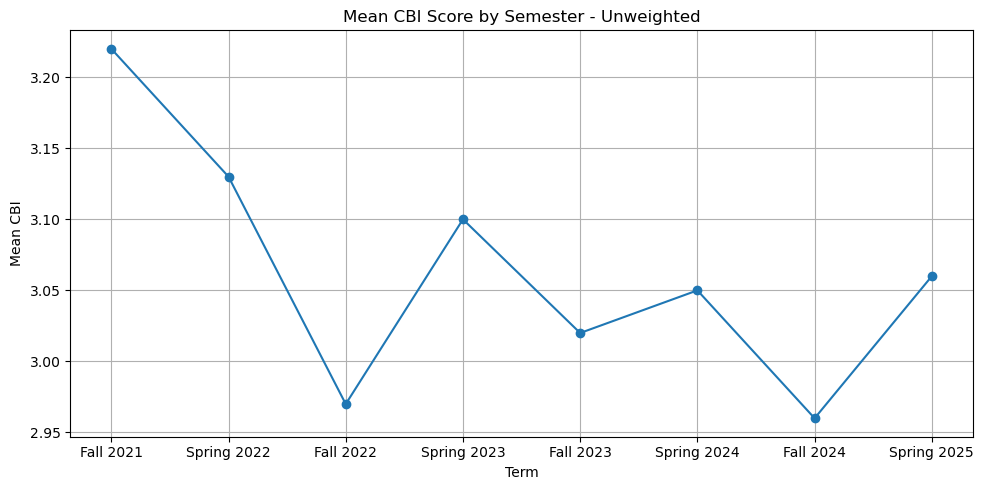

In [50]:
df_trend_means = pd.DataFrame(cbi_term_means)

plt.figure(figsize=(10, 5))
plt.plot(df_trend_means["Term"], df_trend_means["Mean CBI"], marker='o')
plt.title("Mean CBI Score by Semester - Unweighted")
plt.xlabel("Term")
plt.ylabel("Mean CBI")
plt.grid(True)
plt.tight_layout()
plt.show()


Plot CBI by Term: Median

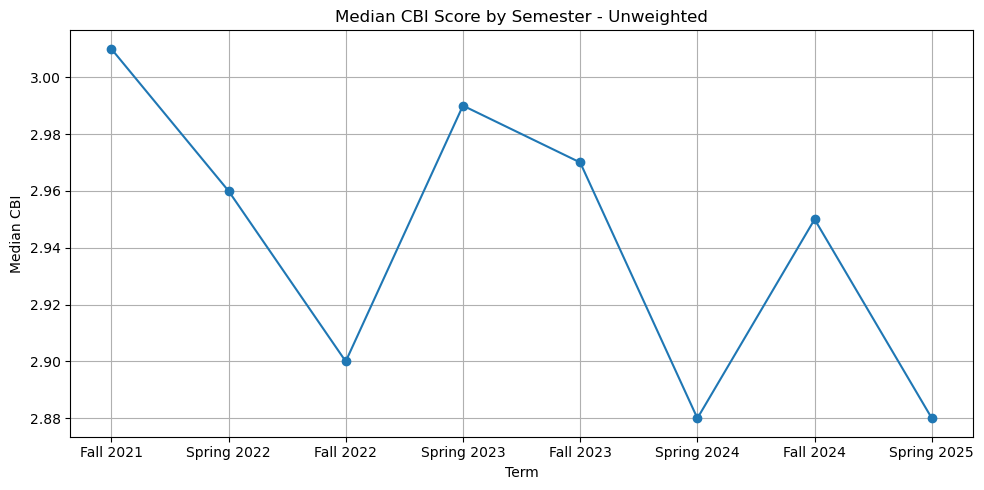

In [51]:
df_trend_medians = pd.DataFrame(cbi_term_medians)

plt.figure(figsize=(10, 5))
plt.plot(df_trend_medians["Term"], df_trend_medians["Median CBI"], marker='o')
plt.title("Median CBI Score by Semester - Unweighted")
plt.xlabel("Term")
plt.ylabel("Median CBI")
plt.grid(True)
plt.tight_layout()
plt.show()


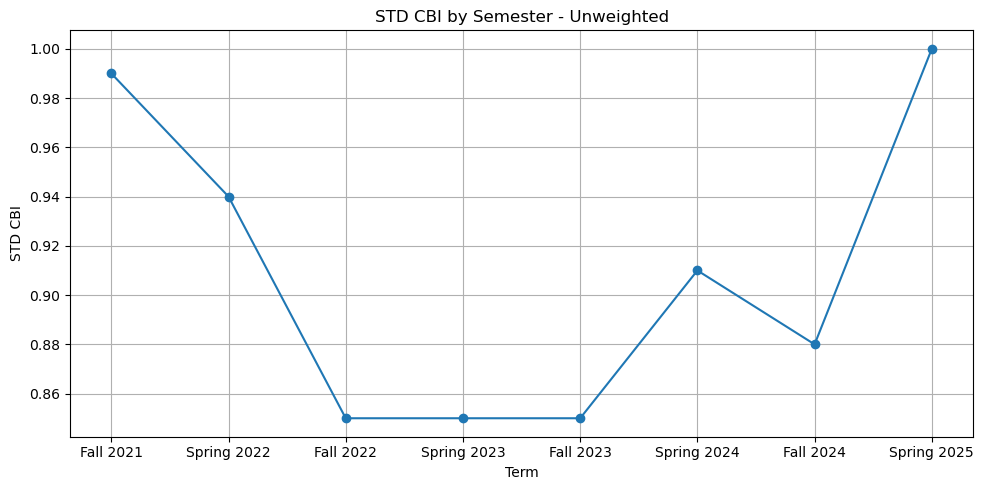

In [52]:
df_trend_std = pd.DataFrame(cbi_term_stds)

plt.figure(figsize=(10, 5))
plt.plot(df_trend_std["Term"], df_trend_std["STD CBI"], marker='o')
plt.title("STD CBI by Semester - Unweighted")
plt.xlabel("Term")
plt.ylabel("STD CBI")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2>Feature Importance Analysis (for Custom Weights)</h2>
Analyze our Terms (DR, OFS, IAS, PCS) for which carry most weight

1. Correlation Analysis
2. Random Forest Analysis

<h4>Feature Importance via Correlation Analysis</h4>

CBI Total first, followed by CBI by Term

In [53]:
# Pearson Correlation: correlate our terms ("DR", "OFS", "IAS", "PCS") against CBI score
correlations_tot = df_CBI[["DR", "OFS", "IAS", "PCS"]].corrwith(df_CBI_analysis["CBI"]).sort_values(ascending=False)

print("CBI Total - Feature Correlation with CBI Score (before weighting):")
print(correlations_tot)

CBI Total - Feature Correlation with CBI Score (before weighting):
OFS    0.849869
IAS    0.682253
PCS    0.524393
DR    -0.268418
dtype: float64


Turn Corrleation Analysis into Percentages, totaling to 100%

In [54]:
correlations_tot_abs = correlations_tot.abs()

# Normalize to sum to 1
weights_tot_corr = (correlations_tot_abs / correlations_tot_abs.sum()).round(4)

print("CBI Total - Feature Importances (Pearson Correlation):")
print(weights_tot_corr)

CBI Total - Feature Importances (Pearson Correlation):
OFS    0.3655
IAS    0.2935
PCS    0.2256
DR     0.1155
dtype: float64


In [55]:
# Pearson Correlation: correlate our terms ("DR", "OFS", "IAS", "PCS") against CBI score
correlations = df_CBI_term[["DR", "OFS", "IAS", "PCS"]].corrwith(df_CBI_term_analysis["CBI"]).sort_values(ascending=False)

print("CBI by Term - Feature Correlation with CBI Score (before weighting):")
print(correlations)

CBI by Term - Feature Correlation with CBI Score (before weighting):
OFS    0.716483
PCS    0.641291
IAS    0.514556
DR    -0.008542
dtype: float64


In [56]:
correlations_abs = correlations.abs()

# Normalize to sum to 1
weights_corr = (correlations_abs / correlations_abs.sum()).round(4)

print("CBI by Term - Feature Importances (Pearson Correlation):")
print(weights_corr)

CBI by Term - Feature Importances (Pearson Correlation):
OFS    0.3809
PCS    0.3410
IAS    0.2736
DR     0.0045
dtype: float64


<h4>Feature Analysis by Correlation Analysis Conclusions: </h4>

Total:
 * OFS (37%) strongest weight
 * IAS (29%) and PCS (22%) have the next strongest weights
 * DR has moderate influence (12%)

 By Term:
 * OFS (38%) strongest weight followed by PCS (34%)
 * IAS (27%) has  moderate influence
 * DR has little to no influence

<h4>Feature Importance via Random Forest</h4>

CBI Total first, followed by CBI by Term

In [57]:
# Random Forest - Feature Importance - CBI Total
x_rf_tot = df_CBI_analysis[["DR", "OFS", "IAS", "PCS"]]
y_rf_tot = df_CBI_analysis["CBI"]

# Run Random Forest Regression
rf_tot_featureimportance_model = RandomForestRegressor(random_state=123)
rf_tot_featureimportance_model.fit(x_rf_tot, y_rf_tot)

# Feature importance with .feature_importances_ (indexed by column names, sorted highest to lowest)
weights_rf_tot = pd.Series(rf_tot_featureimportance_model.feature_importances_, index=x_rf_tot.columns).sort_values(ascending=False)
weights_rf_tot = weights_rf_tot.round(4)

print("CBI Total - Feature Importances (Random Forest):")
print(weights_rf_tot)

CBI Total - Feature Importances (Random Forest):
OFS    0.7268
PCS    0.1979
DR     0.0402
IAS    0.0350
dtype: float64


In [58]:
# Random Forest - Feature Importance - CBI by Term
x_rf = df_CBI_term_analysis[["DR", "OFS", "IAS", "PCS"]]
y_rf = df_CBI_term_analysis["CBI"]

# Run Random Forest Regression
rf_featureimportance_model = RandomForestRegressor(random_state=123)
rf_featureimportance_model.fit(x_rf, y_rf)

# Feature importance with .feature_importances_ (indexed by column names, sorted highest to lowest)
weights_rf = pd.Series(rf_featureimportance_model.feature_importances_, index=x_rf.columns).sort_values(ascending=False)
weights_rf = weights_rf.round(4)

print("CBI by Term - Feature Importances (Random Forest):")
print(weights_rf)


CBI by Term - Feature Importances (Random Forest):
OFS    0.5071
PCS    0.3521
DR     0.0789
IAS    0.0619
dtype: float64


<h4>Feature Analysis by Random Forest Analysis Conclusions: </h4>

Total & By Term:
 * OFS (73%) strongest weight
 * PCS (20%) has the next strongest weight
 * DR & IAS have little influence (<5%)

 By Term:
 * OFS (50.7%) strongest weight
 * PCS (35%) has the next strongest weight
 * DR & IAS have little influence (<10%)

Both Correlation Analysis & Random Forest concluded: 

1) OFS carries the most weight, 

2) PCS carries the second most amount of weight, and 

3) DR carriers little weight

Weights Custom - Correlation Analysis

In [59]:
# CBI Total
weights_corr_tot_dict = weights_tot_corr.to_dict()
weights_rf_tot_dict = weights_rf_tot.to_dict()

print("CBI Total:\n   Feature Importance by Correlation Analysis:", weights_corr_tot_dict)
print("   Feature Importance by Random Forest Analysis:", weights_rf_tot_dict)

# CBI by Term
weights_corr_dict = weights_corr.to_dict()
weights_rf_dict = weights_rf.to_dict()

print("\nCBI by Term:\n   Feature Importance by Correlation Analysis:", weights_corr_dict)
print("   Feature Importance by Random Forest Analysis:", weights_rf_dict)

CBI Total:
   Feature Importance by Correlation Analysis: {'OFS': 0.3655, 'IAS': 0.2935, 'PCS': 0.2256, 'DR': 0.1155}
   Feature Importance by Random Forest Analysis: {'OFS': 0.7268, 'PCS': 0.1979, 'DR': 0.0402, 'IAS': 0.035}

CBI by Term:
   Feature Importance by Correlation Analysis: {'OFS': 0.3809, 'PCS': 0.341, 'IAS': 0.2736, 'DR': 0.0045}
   Feature Importance by Random Forest Analysis: {'OFS': 0.5071, 'PCS': 0.3521, 'DR': 0.0789, 'IAS': 0.0619}


CBI Analysis with New Weights - CBI Total

In [60]:
df_CBI_tot_analysis_corr = df_CBI.copy()

df_CBI_tot_analysis_corr["CBI"] = ((df_CBI_tot_analysis_corr["DR"]  * weights_corr_tot_dict["DR"] +
                               df_CBI_tot_analysis_corr["OFS"] * weights_corr_tot_dict["OFS"] +
                               df_CBI_tot_analysis_corr["IAS"] * weights_corr_tot_dict["IAS"] +
                               df_CBI_tot_analysis_corr["PCS"] * weights_corr_tot_dict["PCS"]).round(2))

In [61]:
df_CBI_tot_analysis_rf = df_CBI.copy()

df_CBI_tot_analysis_rf["CBI"] = ((df_CBI_tot_analysis_rf["DR"]  * weights_rf_tot["DR"] +
                               df_CBI_tot_analysis_rf["OFS"] * weights_rf_tot["OFS"] +
                               df_CBI_tot_analysis_rf["IAS"] * weights_rf_dict["IAS"] +
                               df_CBI_tot_analysis_rf["PCS"] * weights_rf_dict["PCS"]).round(2))

CBI Analysis with New Weights - CBI by Term

In [62]:
df_CBI_term_analysis_corr = df_CBI_term.copy()

df_CBI_term_analysis_corr["CBI"] = ((df_CBI_term_analysis_corr["DR"]  * weights_corr_dict["DR"] +
                               df_CBI_term_analysis_corr["OFS"] * weights_corr_dict["OFS"] +
                               df_CBI_term_analysis_corr["IAS"] * weights_corr_dict["IAS"] +
                               df_CBI_term_analysis_corr["PCS"] * weights_corr_dict["PCS"]).round(2))



In [63]:
df_CBI_term_analysis_rf = df_CBI_term.copy()

df_CBI_term_analysis_rf["CBI"] = ((df_CBI_term_analysis_rf["DR"]  * weights_rf_dict["DR"] +
                               df_CBI_term_analysis_rf["OFS"] * weights_rf_dict["OFS"] +
                               df_CBI_term_analysis_rf["IAS"] * weights_rf_dict["IAS"] +
                               df_CBI_term_analysis_rf["PCS"] * weights_rf_dict["PCS"]).round(2))

Compare CBI with Correlation Weights vs CBI with Random Forest Weights

In [64]:
# CBI Total
# Merge CBI Analyses (Correlation vs Ranom Forest) with ["Course Description", "CBI"]
df_compare_total = df_CBI_tot_analysis_corr.merge(
    df_CBI_tot_analysis_rf, on="Course Description", suffixes=("_corr", "_rf"))

# Correlation between the two versions (Correlation vs Random Forest)
corr_cbi_versions = df_compare_total["CBI_corr"].corr(df_compare_total["CBI_rf"])
print(100*round(corr_cbi_versions, 4), "% Correlation for CBI Total by Correlation vs by Random Forest")

98.89 % Correlation for CBI Total by Correlation vs by Random Forest


In [65]:
# CBI by Term
# Merge CBI Analyses (Correlation vs Ranom Forest) with ["Course Description", "CBI"]
df_compare_term = df_CBI_term_analysis_corr.merge(
    df_CBI_term_analysis_rf, on="Course Description", suffixes=("_corr", "_rf"))

# Correlation between the two versions (Correlation vs Random Forest)
corr_cbi_versions = df_compare_term["CBI_corr"].corr(df_compare_term["CBI_rf"])
print(100*round(corr_cbi_versions, 4), "% Correlation for CBI Total by Correlation vs by Random Forest")

96.33 % Correlation for CBI Total by Correlation vs by Random Forest


<h3> Feature Importance / Weight Analysis Conclusions</h3>

I compared two weighting strategies for our Course Bottleneck Index (CBI): 
1) Correlation-based weights — using Pearson correlation with the original CBI
2) Random Forest-derived weights — using feature importance from a predictive model

The resulting scores were highly consistent:
* 98.99% correlation across total course scores
* 96.33% correlation across term-level scores

Because both models produced near-identical results, **I moved forward with Random Forest weights**, favoring its predictive strength and ability to capture nonlinear patterns in course bottlenecks.

<h1> Correlation Analysis's CBI</h1> 
(For Reference, mostly will use Random Forest)

Summary Stats - Total CBI - Correlation

In [66]:
# Overall stats cbi_tot
cbi_tot_mean_corr = round(df_CBI_tot_analysis_corr["CBI"].mean(), 2)
cbi_tot_median_corr = round(df_CBI_tot_analysis_corr["CBI"].median(), 2)
cbi_tot_std_corr = round(df_CBI_tot_analysis_corr["CBI"].std(), 2)

print("CBI Summary Stats with Correlation Analysis (Overall):")
print(f"Mean CBI: {cbi_tot_mean_corr}")
print(f"Median CBI: {cbi_tot_median_corr}")
print(f"Standard Deviation: {cbi_tot_std_corr}")


# DR min/max and course name
cbi_tot_min_corr = round(df_CBI_tot_analysis_corr["CBI"].min(), 2)
cbi_tot_max_corr = round(df_CBI_tot_analysis_corr["CBI"].max(), 2)
cbi_tot_course_min_corr = df_CBI_tot_analysis_corr.loc[df_CBI_tot_analysis_corr["CBI"] == cbi_tot_min, "Course Description"].tolist() #Course name(s) as list
cbi_tot_course_max_corr = df_CBI_tot_analysis_corr.loc[df_CBI_tot_analysis_corr["CBI"] == cbi_tot_max, "Course Description"].tolist()

print(f"Min CBI: {cbi_tot_min_corr} — Courses: {cbi_tot_course_min_corr}")
print(f"Max CBI: {cbi_tot_max_corr} — Courses: {cbi_tot_course_max_corr}")

# Top highest and lowest DR courses
high_low_count = 10
top_cbi_tot_corr = df_CBI_tot_analysis_corr.nlargest(high_low_count, "CBI")
bottom_cbi_tot_corr = df_CBI_tot_analysis_corr.nsmallest(high_low_count, "CBI")

print(f"\n{high_low_count} Highest CBI Courses:")
#print(top_cbi_tot)
print(top_cbi_tot_corr[["Course Description", "CBI"]])
print(f"\n{high_low_count} Lowest CBI Courses:")
#print(bottom_cbi_tot)
print(bottom_cbi_tot_corr[["Course Description", "CBI"]])

CBI Summary Stats with Correlation Analysis (Overall):
Mean CBI: 0.88
Median CBI: 0.75
Standard Deviation: 0.38
Min CBI: 0.45 — Courses: ['Advanced Web Design', 'Monetizing Independent Gaming']
Max CBI: 1.66 — Courses: []

10 Highest CBI Courses:
                Course Description   CBI
33                         Game AI  1.66
10    Computational Social Science  1.62
57     Natural Language Processing  1.62
65                      STEM Games  1.62
32  Foundation of Info & Inference  1.54
46        Intro to Creative Coding  1.49
7    Bayesian Modeling & Inference  1.47
1              Advanced Web Design  1.46
55   Monetizing Independent Gaming  1.46
29                 Esports Casting  1.45

10 Lowest CBI Courses:
                Course Description   CBI
23                Digital Dilemmas  0.45
59                Online Searching  0.45
26  Digital Storytelling & Culture  0.46
17           Database Dev and Mgmt  0.47
76           Theories of New Media  0.47
24  Digital Discourse and Identi

Summary Stats - By Term CBI - Correlation

In [67]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom courses

# Empty Lists to store some summary stats for graphing
cbi_term_means_corr = []
cbi_term_medians_corr = []
cbi_term_stds_corr = []

for df_semester, group in df_CBI_term_analysis_corr.groupby("Term", sort=False): # sort = False to keep my Terms in academic year order
    # Summary stats (mean, median, std)
    cbi_term_mean = round(group["CBI"].mean(), 2)                                # Mean
    cbi_term_means_corr.append({"Term": df_semester, "Mean CBI": cbi_term_mean}) # Save Mean to cbi_term_means
    cbi_term_median = round(group["CBI"].median(), 2)                                  # Median
    cbi_term_medians_corr.append({"Term": df_semester, "Median CBI": cbi_term_median}) # Save Median to cbi_term_medians
    cbi_term_std = round(group["CBI"].std(), 2)
    cbi_term_stds_corr.append({"Term": df_semester, "STD CBI": cbi_term_std})

    # Print summary stats
    print(f"\n🗓 CBI Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean CBI: {cbi_term_mean}")
    print(f"Median CBI: {cbi_term_median}")
    print(f"Standard Deviation: {cbi_term_std}")

    # Min/Max with course name(s)
    cbi_term_min = round(group["CBI"].min(), 2)
    cbi_term_max = round(group["CBI"].max(), 2)
    cbi_term_course_min = group.loc[group["CBI"] == cbi_term_min, "Course Description"].tolist()
    cbi_term_course_max = group.loc[group["CBI"] == cbi_term_max, "Course Description"].tolist()
    print(f"Min CBI: {cbi_term_min} on Courses: {cbi_term_course_min}")
    print(f"Max CBI: {cbi_term_max} on Courses: {cbi_term_course_max}")

    #Top/Bottom 
    high_low_count = 10
    top_cbi_term = group.nlargest(high_low_count, "CBI")[["Course Description", "CBI"]]
    bottom_cbi_term = group.nsmallest(high_low_count, "CBI")[["Course Description", "CBI"]]
    print(f"\n{df_semester}: {high_low_count} Highest CBI Courses:")
    print(top_cbi_term.to_string(index=False))
    print(f"\n {df_semester}: {high_low_count} Lowest CBI Courses:")
    print(bottom_cbi_term.to_string(index=False))


🗓 CBI Summary for Fall 2021
Mean CBI: 0.91
Median CBI: 0.83
Standard Deviation: 0.38
Min CBI: 0.43 on Courses: ['Digital Storytelling & Culture']
Max CBI: 1.76 on Courses: ['Advanced Web Design', 'Bayesian Modeling & Inference', 'Foundation of Info & Inference', 'Intro to Creative Coding']

Fall 2021: 10 Highest CBI Courses:
            Course Description  CBI
           Advanced Web Design 1.76
 Bayesian Modeling & Inference 1.76
Foundation of Info & Inference 1.76
      Intro to Creative Coding 1.76
 Applied Cyberinfrastruct Conc 1.62
     Designing an Installation 1.42
    Instructional Technologies 1.42
                Special Topics 1.42
      User Interf+Website Dsgn 1.42
          Algorithms for Games 1.38

 Fall 2021: 10 Lowest CBI Courses:
            Course Description  CBI
Digital Storytelling & Culture 0.43
              Online Searching 0.45
Digital Discourse and Identity 0.47
         Theories of New Media 0.47
    Social Media and Ourselves 0.48
  Collaborating: Online 

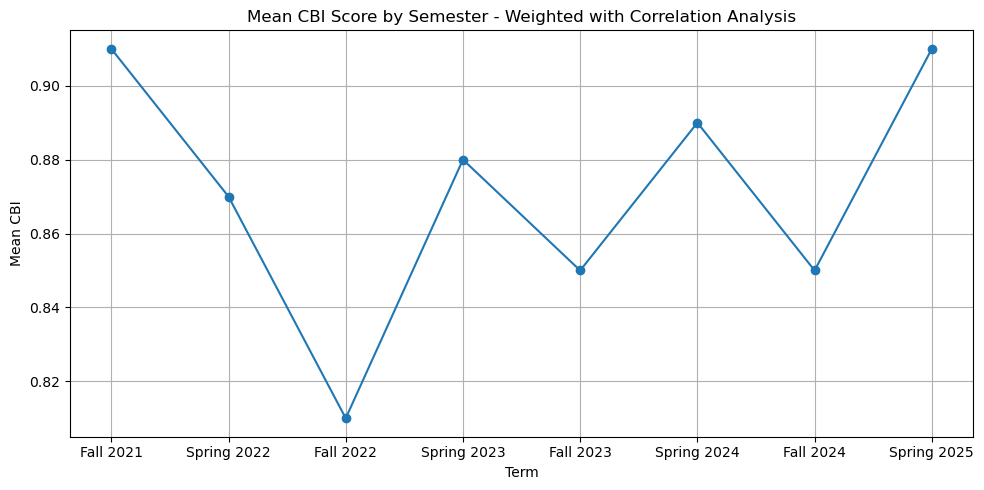

In [68]:
df_trend_means_corr = pd.DataFrame(cbi_term_means_corr)

plt.figure(figsize=(10, 5))
plt.plot(df_trend_means_corr["Term"], df_trend_means_corr["Mean CBI"], marker='o')
plt.title("Mean CBI Score by Semester - Weighted with Correlation Analysis")
plt.xlabel("Term")
plt.ylabel("Mean CBI")
plt.grid(True)
plt.tight_layout()
plt.show()

<h1> Random Forest's CBI</h1>

Summary Stats - Total CBI - Random Forest

In [69]:
# Overall stats cbi_tot
cbi_tot_mean = round(df_CBI_tot_analysis_rf["CBI"].mean(), 2)
cbi_tot_median = round(df_CBI_tot_analysis_rf["CBI"].median(), 2)
cbi_tot_std = round(df_CBI_tot_analysis_rf["CBI"].std(), 2)

print("CBI Summary Stats (Overall):")
print(f"Mean CBI: {cbi_tot_mean}")
print(f"Median CBI: {cbi_tot_median}")
print(f"Standard Deviation: {cbi_tot_std}")


# DR min/max and course name
cbi_tot_min = round(df_CBI_tot_analysis_rf["CBI"].min(), 2)
cbi_tot_max = round(df_CBI_tot_analysis_rf["CBI"].max(), 2)
cbi_tot_course_min = df_CBI_tot_analysis_rf.loc[df_CBI_tot_analysis_rf["CBI"] == cbi_tot_min, "Course Description"].tolist() #Course name(s) as list
cbi_tot_course_max = df_CBI_tot_analysis_rf.loc[df_CBI_tot_analysis_rf["CBI"] == cbi_tot_max, "Course Description"].tolist()

print(f"Min CBI: {cbi_tot_min} — Courses: {cbi_tot_course_min}")
print(f"Max CBI: {cbi_tot_max} — Courses: {cbi_tot_course_max}")

# Top highest and lowest DR courses
high_low_count = 10
top_cbi_tot = df_CBI_tot_analysis_rf.nlargest(high_low_count, "CBI")
bottom_cbi_tot = df_CBI_tot_analysis_rf.nsmallest(high_low_count, "CBI")

print(f"\n{high_low_count} Highest CBI Courses:")
#print(top_cbi_tot)
print(top_cbi_tot[["Course Description", "CBI"]])
print(f"\n{high_low_count} Lowest CBI Courses:")
#print(bottom_cbi_tot)
print(bottom_cbi_tot[["Course Description", "CBI"]])

CBI Summary Stats (Overall):
Mean CBI: 1.41
Median CBI: 1.12
Standard Deviation: 0.67
Min CBI: 0.75 — Courses: ['Database Dev and Mgmt', 'Digital Dilemmas', 'Intellectual Property/Copyrigh', 'Intro to Info Tech', 'Online Searching']
Max CBI: 2.61 — Courses: ['Game AI']

10 Highest CBI Courses:
                Course Description   CBI
33                         Game AI  2.61
65                      STEM Games  2.60
10    Computational Social Science  2.59
32  Foundation of Info & Inference  2.59
57     Natural Language Processing  2.59
46        Intro to Creative Coding  2.58
1              Advanced Web Design  2.57
3    Applied Cyberinfrastruct Conc  2.56
7    Bayesian Modeling & Inference  2.56
55   Monetizing Independent Gaming  2.27

10 Lowest CBI Courses:
                Course Description   CBI
17           Database Dev and Mgmt  0.75
23                Digital Dilemmas  0.75
44  Intellectual Property/Copyrigh  0.75
49              Intro to Info Tech  0.75
59                Online 

Summary Stats - By Term CBI - Random Forest

In [70]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom courses

# Empty Lists to store some summary stats for graphing
cbi_term_means = []
cbi_term_medians = []
cbi_term_stds = []

for df_semester, group in df_CBI_term_analysis_rf.groupby("Term", sort=False): # sort = False to keep my Terms in academic year order
    # Summary stats (mean, median, std)
    cbi_term_mean = round(group["CBI"].mean(), 2)                           # Mean
    cbi_term_means.append({"Term": df_semester, "Mean CBI": cbi_term_mean}) # Save Mean to cbi_term_means
    cbi_term_median = round(group["CBI"].median(), 2)                             # Median
    cbi_term_medians.append({"Term": df_semester, "Median CBI": cbi_term_median}) # Save Median to cbi_term_medians
    cbi_term_std = round(group["CBI"].std(), 2)
    cbi_term_stds.append({"Term": df_semester, "STD CBI": cbi_term_std})

    # Print summary stats
    print(f"\n🗓 CBI Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean CBI: {cbi_term_mean}")
    print(f"Median CBI: {cbi_term_median}")
    print(f"Standard Deviation: {cbi_term_std}")

    # Min/Max with course name(s)
    cbi_term_min = round(group["CBI"].min(), 2)
    cbi_term_max = round(group["CBI"].max(), 2)
    cbi_term_course_min = group.loc[group["CBI"] == cbi_term_min, "Course Description"].tolist()
    cbi_term_course_max = group.loc[group["CBI"] == cbi_term_max, "Course Description"].tolist()
    print(f"Min CBI: {cbi_term_min} on Courses: {cbi_term_course_min}")
    print(f"Max CBI: {cbi_term_max} on Courses: {cbi_term_course_max}")

    #Top/Bottom 
    high_low_count = 10
    top_cbi_term = group.nlargest(high_low_count, "CBI")[["Course Description", "CBI"]]
    bottom_cbi_term = group.nsmallest(high_low_count, "CBI")[["Course Description", "CBI"]]
    print(f"\n{df_semester}: {high_low_count} Highest CBI Courses:")
    print(top_cbi_term.to_string(index=False))
    print(f"\n {df_semester}: {high_low_count} Lowest CBI Courses:")
    print(bottom_cbi_term.to_string(index=False))


🗓 CBI Summary for Fall 2021
Mean CBI: 0.96
Median CBI: 0.92
Standard Deviation: 0.44
Min CBI: 0.55 on Courses: ['Online Searching']
Max CBI: 2.01 on Courses: ['Intro to Creative Coding']

Fall 2021: 10 Highest CBI Courses:
            Course Description  CBI
      Intro to Creative Coding 2.01
Foundation of Info & Inference 2.00
           Advanced Web Design 1.96
 Bayesian Modeling & Inference 1.94
 Applied Cyberinfrastruct Conc 1.92
    Instructional Technologies 1.63
     Designing an Installation 1.60
                Special Topics 1.60
      User Interf+Website Dsgn 1.59
Simulation and Problem Solving 1.55

 Fall 2021: 10 Lowest CBI Courses:
            Course Description  CBI
              Online Searching 0.55
              Digital Dilemmas 0.56
Digital Storytelling & Culture 0.56
         Theories of New Media 0.57
Digital Discourse and Identity 0.58
  Collaborating: Online Commun 0.59
         Database Dev and Mgmt 0.59
            Intro to Info Tech 0.59
          Quantitati

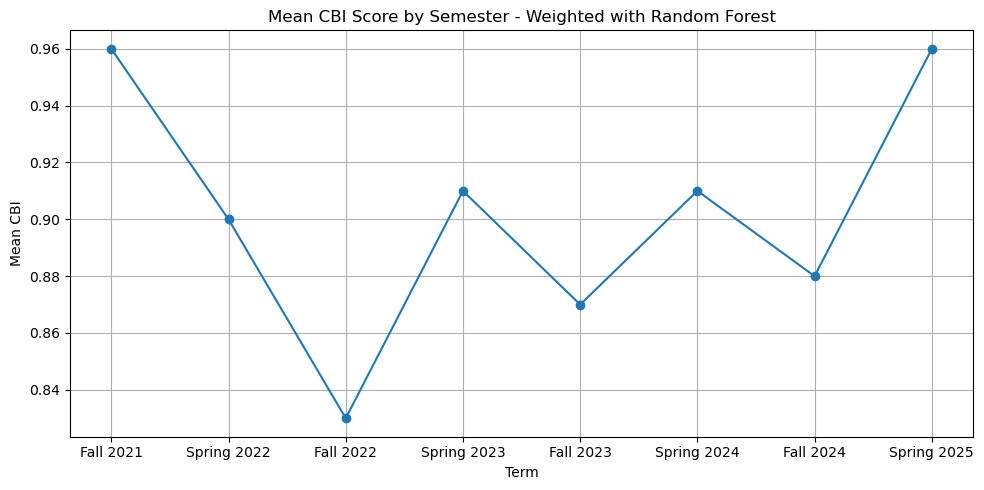

In [71]:
df_trend_means = pd.DataFrame(cbi_term_means)

plt.figure(figsize=(10, 5))
plt.plot(df_trend_means["Term"], df_trend_means["Mean CBI"], marker='o')
plt.title("Mean CBI Score by Semester - Weighted with Random Forest")
plt.xlabel("Term")
plt.ylabel("Mean CBI")
plt.grid(True)
plt.tight_layout()
plt.show()

<h1> Actionable Callouts - Next Workbook </h1>

In [72]:
# Create folder
CBI_action_folder_path = os.path.join(os.getcwd(), "CBI Analysis_Actionable Insights")
os.makedirs(CBI_action_folder_path, exist_ok=True)

# DFs to save
df_dict = {"df_CBI_tot_analysis_corr": df_CBI_tot_analysis_corr,
    "df_CBI_tot_analysis_rf": df_CBI_tot_analysis_rf,
    "df_CBI_term_analysis_corr": df_CBI_term_analysis_corr,
    "df_CBI_term_analysis_rf": df_CBI_term_analysis_rf,
    "df_CBI_analysis": df_CBI_analysis,
    "df_CBI_term_analysis": df_CBI_term_analysis}

for name, df in df_dict.items():
    filepath = os.path.join(CBI_action_folder_path, f"{name}.xlsx")
    df.to_excel(filepath, index=False)
    print(f"Saved {name} to Folder CBI Analysis_Actionable Insights")

# Dictionaries to save
dict_dict = {"weights_corr_tot_dict": weights_corr_tot_dict,
    "weights_corr_dict": weights_corr_dict,
    "weights_rf_tot_dict": weights_rf_tot_dict,
    "weights_rf_dict": weights_rf_dict}

for name, d in dict_dict.items():
    df = pd.DataFrame.from_dict(d, orient="index", columns=["Weight"])
    df.index.name = "Component"
    filepath = os.path.join(CBI_action_folder_path, f"{name}.xlsx")
    df.to_excel(filepath)
    print(f"Saved {name} dictionary to Folder CBI Analysis_Actionable Insights")


Saved df_CBI_tot_analysis_corr to Folder CBI Analysis_Actionable Insights
Saved df_CBI_tot_analysis_rf to Folder CBI Analysis_Actionable Insights
Saved df_CBI_term_analysis_corr to Folder CBI Analysis_Actionable Insights
Saved df_CBI_term_analysis_rf to Folder CBI Analysis_Actionable Insights
Saved df_CBI_analysis to Folder CBI Analysis_Actionable Insights
Saved df_CBI_term_analysis to Folder CBI Analysis_Actionable Insights
Saved weights_corr_tot_dict dictionary to Folder CBI Analysis_Actionable Insights
Saved weights_corr_dict dictionary to Folder CBI Analysis_Actionable Insights
Saved weights_rf_tot_dict dictionary to Folder CBI Analysis_Actionable Insights
Saved weights_rf_dict dictionary to Folder CBI Analysis_Actionable Insights
